# Initial set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '_CURRENT/“COOP/UncertaintyPaper'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['README.md', 'NP', 'meta', 'data', 'reg_paper.ipynb', 'NP_LSTM_META', 'LSTM_META', 'LSTM']


In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [4]:
import numpy as np
import torch.nn as nn
import pickle
import random
import torch
from torch.autograd import Variable
from numpy import genfromtxt
from matplotlib import pylab as plt

# Create train / val / test datasets

In [5]:
def getScale(path, models):
    bound_list = []
    for model in models:
        bound_file = str(model) + '_bound.csv'
        bound = genfromtxt(os.path.join(path, bound_file), delimiter=',')
        bound_list.append(bound)
    bound_list = np.array(bound_list)        
    scale = np.array([np.max(bound_list[:, :, 0], axis=0), np.min(bound_list[:, :, 1], axis=0)])
    abs_scale = np.max(abs(scale), axis=0)
    return abs_scale

def makeTrainingSet(path, model, correct_idx, problem_idx, abs_scale):

    out_pkl = str(model) + '.pkl'
    files = os.listdir(path)
    all_data = []
    for file in files:
        pkl_files = os.listdir(os.path.join(path, file))
        for pkl_file in pkl_files:
            with open(os.path.join(path, file, pkl_file), 'rb') as f:
                one_sample = pickle.load(f)
                if len(one_sample) != 159:
                    continue
                if len(one_sample[0]) != 88:
                    continue
                one_sample = np.array(one_sample)
                if one_sample.shape != (159, 88):
                    continue
                all_data.append(one_sample)

    all_data = np.array(all_data)
    Z = all_data[:, :, correct_idx]
    X = all_data[:, :, problem_idx]
    all_data = np.concatenate((Z, X), axis=2)

    # Normalization
    for i in range(all_data.shape[2]):
        all_data[:, :, i] /= abs_scale[i]
    # Save normalized pkl files
    pickle.dump(all_data, open(out_pkl, 'ab'))
    
def makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, kind):
    sub_paths = os.listdir(path)
    all_data = []
    for sub_path in sub_paths:
        out_pkl = str(model) + '_' + kind + '.pkl'
        files = os.listdir(os.path.join(path, sub_path))
        
        for file in files:
            pkl_files = os.listdir(os.path.join(path, sub_path, file))
            for pkl_file in pkl_files:
                with open(os.path.join(path, sub_path, file, pkl_file), 'rb') as f:
                    one_sample = pickle.load(f)
                    if len(one_sample) != 159:
                        continue
                    if len(one_sample[0]) != 88:
                        continue
                    one_sample = np.array(one_sample)
                    if one_sample.shape != (159, 88):
                        continue
                    all_data.append(one_sample)

    all_data = np.array(all_data)
    Z = all_data[:, :, correct_idx]
    X = all_data[:, :, problem_idx]
    all_data = np.concatenate((Z, X), axis=2)

    # Normalization
    for i in range(all_data.shape[2]):
        all_data[:, :, i] /= abs_scale[i]
    # Save normalized pkl files
    pickle.dump(all_data, open(out_pkl, 'ab'))

In [6]:
models = [442, 607, 612, 614, 616, 617, 620, 714, 722]

In [8]:
# path = "../meta/meta_bound"
# abs_scale = getScale(path, models)

# # Set sensor index
# raw_problem_idx = [49, 50, 51, 52, 53, 54, 87,
#                    10, 11, 12, 13, 14, 16, 17, 19, 29]
# raw_correct_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 31, 34, 41, 44, 60]
# correct_idx = []
# problem_idx = []
# # M1inus one for each index
# for idx in raw_correct_idx:
#     correct_idx.append(idx - 1)
# correct_l = len(correct_idx)

# for idx in raw_problem_idx:
#     problem_idx.append(idx - 1)
# problem_l = len(problem_idx)

In [9]:
# path_general = "../new_gan"
# for model in models:
#     path = os.path.join(path_general, str(model), "train")
#     makeTrainingSet(path, model, correct_idx, problem_idx, abs_scale)

In [10]:
# path_general = "../new_gan"
# for model in models:
#     path = os.path.join(path_general, str(model), "val")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "val")

# for model in models:
#     path = os.path.join(path_general, str(model), "test")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "test")

# for model in models:
#     path = os.path.join(path_general, str(model), "ab")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "ab")

In [7]:
training = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + ".pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        training[model] = one_sample

In [8]:
validation = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_val.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        length = one_sample.shape[0]
        select_list = [i for i in range(length)]
        random.shuffle(select_list)
        validation[model] = one_sample[select_list, :]

In [9]:
ab = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_ab.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        ab[model] = one_sample

In [10]:
test = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_test.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        test[model] = one_sample

# Models

## NP_LSTM

In [11]:
## Network structure
class NP_LSTM(nn.Module):
    def __init__(self):
        super(NP_LSTM, self).__init__()
        self.r_dim = 128
        self.z_dim = 128
        self.h_param = 500
        self.g_param = 500

        # LSTM parameters
        self.x_dim = 14
        self.y_dim = 16
        self.input_dim = 30
        self.output_dim = 16
        self.hidden_dim = 500
        self.num_layers = 2
        self.lstm_h = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.lstm_g = nn.LSTM(self.x_dim + self.z_dim, self.hidden_dim, self.num_layers)
        # Define output layer
        # self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        self.g_l = nn.Linear(self.g_param, self.output_dim)

        self.h_l = nn.Linear(self.h_param, self.r_dim)

        self.r_to_z_mean = nn.Linear(self.r_dim, self.z_dim)
        self.r_to_z_log_var = nn.Linear(self.r_dim, self.z_dim)

    def point_grad_to(self, target):
        '''
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)

    def aggregate(self, rc):
        return torch.mean(rc, dim=0)

    def h(self, input):
        h_out, self.hidden = self.lstm_h(input)
        h_out = self.h_l(h_out)
        return h_out

    def g(self, input):
        g_out, _ = self.lstm_g(input, self.hidden)
        g_out = self.g_l(g_out)
        return g_out

    def xy_to_z(self, x, y):
        context = torch.cat([x, y], dim=2)
        rc = self.h(context)
        r = self.aggregate(rc)
        mu = self.r_to_z_mean(r)
        log_var = self.r_to_z_log_var(r)
        return mu, log_var

    def xz_to_y(self, x, z):
        std = torch.exp(0.5 * z[0])
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(z[1])
        z = z.unsqueeze(0).expand(self.output_length, -1, -1)
        y = self.g(torch.cat([z, x], dim=2))
        return y

    def forward(self, x_context, y_context, x_target, x_all=None, y_all=None):
        # context = torch.cat([x_context, y_context.unsqueeze(2)], dim=2)
        # rC = self.h(context)
        # r = torch.mean(rC, dim=1)
        # mu = self.r_to_z_mean(r)
        # logVar = self.r_to_z_logVar(r)
        self.output_length = x_target.shape[0]
        z_context = self.xy_to_z(x_context, y_context)
        if x_all is not None:
            z_all = self.xy_to_z(x_all, y_all)
        else:
            z_all = None

        y_pred = self.xz_to_y(x_target, z_context)
        return y_pred, z_context, z_all

### NP-specific losses

In [12]:
def kl_div_gaussians(mu_q, logvar_q, mu_p, logvar_p):
    var_p = torch.exp(logvar_p)
    kl_div = (torch.exp(logvar_q) + (mu_q - mu_p) ** 2) / var_p - 1.0 + logvar_p - logvar_q
    kl_div = 0.5 * kl_div.sum()
    return kl_div


def np_loss(y_pred, y_target, z_all, z_context):
    MSELoss = torch.nn.MSELoss()(y_pred, y_target)
    KLD = kl_div_gaussians(z_all[0], z_all[1], z_context[0], z_context[1])
    return MSELoss + KLD

## LSTM

In [13]:
## Network structure
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.input_dim = 14
        self.hidden_dim = 500
        self.num_layers = 2
        self.output_dim = 16
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        # Define output layer
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
#         self.tanh = nn.Tanh()

    def point_grad_to(self, target):
        '''
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)

    def forward(self, x):
        # shape of input  (seq_length, batch, input_dim)
        # shape of output (seq_length, batch, hidden_dim)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out)
#         y_pred = self.tanh(y_pred)
        return y_pred

### MSE loss

In [14]:
MSELoss = torch.nn.MSELoss()

# Training

In [16]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

## NP_LSTM with meta learning

In [21]:
# Start training
Step = 4000 # 4000
batch_size = 16
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
update_lr = 1e-4
update_step = 5
weight_flag = 0
net = NP_LSTM().cuda()
output_file = 'NP_LSTM_META'

# Optimizers
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

task_order = models.copy()

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(meta_optimizer, meta_lr_decay, step, schedule)

    random.shuffle(task_order)
    for vehicle in task_order:
        # Choose data
        length = training[vehicle].shape[0]
        batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]
        
        x_batch = training[vehicle][batch_list, :, :14].cuda().transpose(0, 1)
        y_batch = training[vehicle][batch_list, :, 14:].cuda().transpose(0, 1)
        x_context = x_batch[:80, :, :]
        y_context = y_batch[:80, :, :]

        x_target = x_batch[80:, :, :]
        y_target = y_batch[80:, :, :]
#         x_y_target = torch.cat([x_target, y_target], dim=2)

        # Initialize network
        net_i = NP_LSTM().cuda()
        net_i.load_state_dict(net.state_dict())
        update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)

        # Update process
        for j in range(update_step):
            y_pred, z_context, z_all = net_i(x_context, y_context, x_target, x_batch, y_batch)
            update_loss = np_loss(y_pred, y_target, z_all, z_context)
            update_optimizer.zero_grad()
            update_loss.backward(retain_graph=True)
            update_optimizer.step()
        net.point_grad_to(net_i)
        meta_optimizer.step()
   
    # Validation loss
    val_loss = 0
    for vehicle in validation:
        x_batch = validation[vehicle][:100, :, :14].cuda().transpose(0, 1)
        y_batch = validation[vehicle][:100, :, 14:].cuda().transpose(0, 1)
        x_context = x_batch[:80, :, :]
        y_context = y_batch[:80, :, :]

        x_target = x_batch[80:, :, :]
        y_target = y_batch[80:, :, :]

        y_pred, _, _ = net(x_context, y_context, x_target)
        val_loss += torch.nn.MSELoss()(y_pred, y_target)
        
    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data

#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)
#         x_context = x_batch[:80, :, :]
#         y_context = y_batch[:80, :, :]

#         x_target = x_batch[80:, :, :]
#         y_target = y_batch[80:, :, :]

#         y_pred, _, _ = net(x_context, y_context, x_target)
#         ab_loss += torch.nn.MSELoss()(y_pred, y_target)
 
#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)
#         x_context = x_batch[:80, :, :]
#         y_context = y_batch[:80, :, :]

#         x_target = x_batch[80:, :, :]
#         y_target = y_batch[80:, :, :]

#         y_pred, _, _ = net(x_context, y_context, x_target)
#         test_loss += torch.nn.MSELoss()(y_pred, y_target)
        
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))
        
# #     testTraining_loss = 0
# #     for i in range(testTraining_batch_num - 1):
# #         x_testTraining_batch = x_testTraining_batch_list[i].cuda()
# #         y_testTraining_batch = y_testTraining_batch_list[i].cuda()
# #         testTraining_loss += MSELoss(net(x_testTraining_batch), y_testTraining_batch)
# #         del x_testTraining_batch
# #         del y_testTraining_batch
# #         torch.cuda.empty_cache()
# #     testTraining_loss = testTraining_loss/testTraining_batch_num

Start training
epoch: 0 || loss: 0.177132
epoch: 1 || loss: 0.062355
epoch: 2 || loss: 0.032775
epoch: 3 || loss: 0.024628
epoch: 4 || loss: 0.019173
epoch: 5 || loss: 0.017912
epoch: 6 || loss: 0.016699
epoch: 7 || loss: 0.015927
epoch: 8 || loss: 0.018342
epoch: 9 || loss: 0.015521
epoch: 10 || loss: 0.014663
epoch: 11 || loss: 0.013622
epoch: 12 || loss: 0.018087
epoch: 13 || loss: 0.012718
epoch: 14 || loss: 0.019244
epoch: 15 || loss: 0.012403
epoch: 16 || loss: 0.012775
epoch: 17 || loss: 0.012448
epoch: 18 || loss: 0.012742
epoch: 19 || loss: 0.011959
epoch: 20 || loss: 0.014046
epoch: 21 || loss: 0.012896
epoch: 22 || loss: 0.012016
epoch: 23 || loss: 0.012386
epoch: 24 || loss: 0.012689
epoch: 25 || loss: 0.012380
epoch: 26 || loss: 0.012000
epoch: 27 || loss: 0.014060
epoch: 28 || loss: 0.016917
epoch: 29 || loss: 0.012092
epoch: 30 || loss: 0.011073
epoch: 31 || loss: 0.017042
epoch: 32 || loss: 0.010955
epoch: 33 || loss: 0.014162
epoch: 34 || loss: 0.013746
epoch: 35 || lo

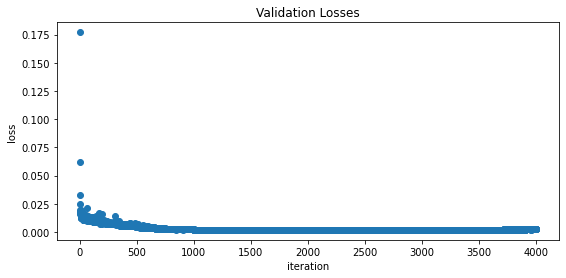

In [22]:
# Visualize losses
plt.title('Validation Losses')
plt.plot(val_losses, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

##  LSTM with meta learning

In [23]:
# Start training
Step = 4000 # 4000
batch_size = 16
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
update_lr = 1e-4
update_step = 5
weight_flag = 0
net = LSTM().cuda()
output_file = 'LSTM_META'

# Optimizers
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

task_order = models.copy()

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(meta_optimizer, meta_lr_decay, step, schedule)

    random.shuffle(task_order)
    for vehicle in task_order:
        # Choose data
        length = training[vehicle].shape[0]
        batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]

        x_batch = training[vehicle][batch_list, :, :14].cuda().transpose(0, 1)
        y_batch = training[vehicle][batch_list, :, 14:].cuda().transpose(0, 1)

        # Initialize network
        net_i = LSTM().cuda()
        net_i.load_state_dict(net.state_dict())
        update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)

        # Update process
        for j in range(update_step):
            y_pred = net_i(x_batch)
            update_loss = MSELoss(y_pred, y_batch)
            update_optimizer.zero_grad()
            update_loss.backward(retain_graph=True)
            update_optimizer.step()
        net.point_grad_to(net_i)
        meta_optimizer.step()
      
    # Validation loss
    val_loss = 0
    for vehicle in validation:
        x_batch = validation[vehicle][:100, :, :14].cuda().transpose(0, 1)
        y_batch = validation[vehicle][:100, :, 14:].cuda().transpose(0, 1)

        y_pred = net(x_batch)
        val_loss += MSELoss(y_pred, y_batch)
      
    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data
      
#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         ab_loss += MSELoss(y_pred, y_batch)

#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         test_loss += MSELoss(y_pred, y_batch)
      
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))

Start training
epoch: 0 || loss: 0.177640
epoch: 1 || loss: 0.086950
epoch: 2 || loss: 0.040674
epoch: 3 || loss: 0.026728
epoch: 4 || loss: 0.019194
epoch: 5 || loss: 0.021338
epoch: 6 || loss: 0.012545
epoch: 7 || loss: 0.012822
epoch: 8 || loss: 0.012076
epoch: 9 || loss: 0.012271
epoch: 10 || loss: 0.012167
epoch: 11 || loss: 0.010629
epoch: 12 || loss: 0.011330
epoch: 13 || loss: 0.011974
epoch: 14 || loss: 0.011630
epoch: 15 || loss: 0.010693
epoch: 16 || loss: 0.010681
epoch: 17 || loss: 0.011079
epoch: 18 || loss: 0.010210
epoch: 19 || loss: 0.010849
epoch: 20 || loss: 0.013926
epoch: 21 || loss: 0.010750
epoch: 22 || loss: 0.011084
epoch: 23 || loss: 0.011234
epoch: 24 || loss: 0.011512
epoch: 25 || loss: 0.011213
epoch: 26 || loss: 0.010737
epoch: 27 || loss: 0.010400
epoch: 28 || loss: 0.011785
epoch: 29 || loss: 0.009749
epoch: 30 || loss: 0.010228
epoch: 31 || loss: 0.010205
epoch: 32 || loss: 0.013040
epoch: 33 || loss: 0.010389
epoch: 34 || loss: 0.010920
epoch: 35 || lo

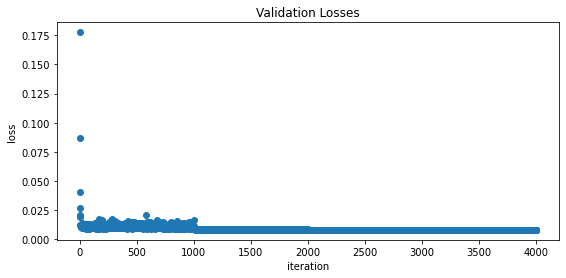

In [24]:
# Visualize losses
plt.title('Validation Losses')
plt.plot(val_losses, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

## LSTM without meta learning

In [25]:
# Start training
Step = 4000
batch_size = 128
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
weight_flag = 0
net = LSTM().cuda()
output_file = 'LSTM'

# Optimizers
optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

# Mix data from all vehicles/tasks together
training_all = torch.cat(list(training.values()))
validation_all = torch.cat(list(validation.values()))

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(optimizer, meta_lr_decay, step, schedule)
    
    # Choose data
    length = training_all.shape[0]
    batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]

    x_batch = training_all[batch_list, :, :14].cuda().transpose(0, 1)
    y_batch = training_all[batch_list, :, 14:].cuda().transpose(0, 1)

    # Regular update process
    y_pred = net(x_batch)
    loss = MSELoss(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    val_loss = 0
    
    x_batch = validation_all[:100, :, :14].cuda().transpose(0, 1)
    y_batch = validation_all[:100, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)
    val_loss += MSELoss(y_pred, y_batch)

    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data
      
#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         ab_loss += MSELoss(y_pred, y_batch)

#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         test_loss += MSELoss(y_pred, y_batch)
      
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))

Start training
epoch: 0 || loss: 0.058013
epoch: 1 || loss: 0.035311
epoch: 2 || loss: 0.006771
epoch: 3 || loss: 0.530253
epoch: 4 || loss: 0.007190
epoch: 5 || loss: 0.015436
epoch: 6 || loss: 0.029014
epoch: 7 || loss: 0.037326
epoch: 8 || loss: 0.042189
epoch: 9 || loss: 0.044942
epoch: 10 || loss: 0.046350
epoch: 11 || loss: 0.046843
epoch: 12 || loss: 0.046667
epoch: 13 || loss: 0.045967
epoch: 14 || loss: 0.044815
epoch: 15 || loss: 0.043241
epoch: 16 || loss: 0.041239
epoch: 17 || loss: 0.038771
epoch: 18 || loss: 0.035767
epoch: 19 || loss: 0.032136
epoch: 20 || loss: 0.027762
epoch: 21 || loss: 0.022543
epoch: 22 || loss: 0.016522
epoch: 23 || loss: 0.010331
epoch: 24 || loss: 0.006158
epoch: 25 || loss: 0.006921
epoch: 26 || loss: 0.008861
epoch: 27 || loss: 0.008405
epoch: 28 || loss: 0.006610
epoch: 29 || loss: 0.005091
epoch: 30 || loss: 0.004424
epoch: 31 || loss: 0.004403
epoch: 32 || loss: 0.004663
epoch: 33 || loss: 0.004934
epoch: 34 || loss: 0.005063
epoch: 35 || lo

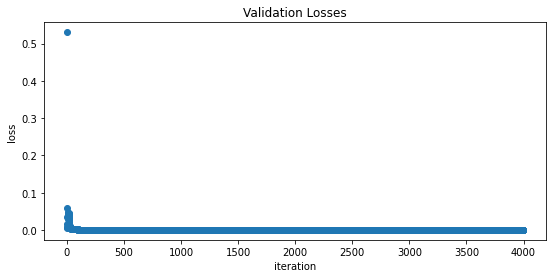

In [26]:
# Visualize losses
plt.title('Validation Losses')
plt.plot(val_losses, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

# Possible ML methods to visualize 

In [ ]:
from sklearn import mixture
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn import decomposition

# pca = decomposition.PCA(n_components=60)
# pca.fit(val)
# test_result0 = pca.transform(test_result)
# val0 = pca.transform(val)
# test_result_dtc0 = pca.transform(test_result_dtc)

g = EllipticEnvelope(contamination=0.01, random_state=0)
# g = OneClassSVM(gamma='auto', degree=5, kernel='rbf',nu=0.1)
# g = mixture.GaussianMixture(n_components=1, covariance_type='full', max_iter=100000)
# g = IsolationForest(contamination=0.015, n_estimators=5000, behaviour='new', max_samples=2000)
# g.fit(val0) 
# print(np.sum(np.sum((g.predict(val0)>0)*1)/val0.shape[0]))
# print(np.sum(np.sum((g.predict(test_result0)>0)*1)/test_result0.shape[0]))
# print(np.sum(np.sum((g.predict(test_result_dtc0)<0)*1)/test_result_dtc0.shape[0]))

# Testing

In [24]:
def getNum(val_diff, val_list):
    val_diff = np.std(val_diff, axis=1)
#     val_diff = np.mean(val_diff, axis=1)
#     each_case = val_diff > 3 * val_list
    each_case = np.sum(val_diff > val_list, axis=1)
    return np.sum(each_case > 1)

## Test NP_LSTM

In [26]:
net = NP_LSTM().cuda()
net.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'NP/model_4968_0.00167.ckpt'))) # model with meta learning

batch_size = 100

# test
val_list = []  
for vehicle in validation:
    x_batch = validation[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = validation[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    val_diff = val_diff.reshape([-1, 16])
#     val_diff = np.std(val_diff, axis=0)
    mean = np.mean(val_diff, axis=0)
    std = np.std(val_diff, axis=0)
#     thresh = np.mean(val_diff, axis=0)
    thresh = abs(mean) + 3 * std
    val_list.append(thresh)
val_np = np.array(val_list)

ab_np_list = []
i = 0
for vehicle in ab:
    x_batch = ab[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = ab[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    
    ab_np_list.append(getNum(val_diff, val_list[i]))
    i += 1

test_np_list = []
i = 0
for vehicle in test:
    x_batch = test[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = test[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target

    test_np_list.append(getNum(val_diff, val_list[i]))
    i += 1

In [27]:
print(ab_np_list)

[0, 31, 0, 14, 0, 7, 2, 0, 0]


In [28]:
print(test_np_list)

[0, 7, 0, 0, 1, 0, 0, 0, 0]


## Test LSTM

In [30]:
net = LSTM().cuda()
net.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'meta/model_4279_0.00787.ckpt'))) # model with meta learning

batch_size = 100

# test
val_list = []   
for vehicle in validation:
    x_batch = validation[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = validation[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    val_diff = val_diff.reshape([-1, 16])
#     val_diff = np.std(val_diff, axis=0)
    mean = np.mean(val_diff, axis=0)
    std = np.std(val_diff, axis=0)
#     thresh = np.mean(val_diff, axis=0)
    thresh = abs(mean) + 3 * std
    val_list.append(thresh)
val_np = np.array(val_list)

i = 0
ab_meta_list = []
len_ab_list = []
for vehicle in ab:
    x_batch = ab[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = ab[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    ab_meta_list.append(getNum(val_diff, val_list[i]))
    len_ab_list.append(val_diff.shape[0])
    i += 1

i = 0
test_meta_list = []
len_test_list = []
for vehicle in test:
    x_batch = test[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = test[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    test_meta_list.append(getNum(val_diff, val_list[i]))
    len_test_list.append(val_diff.shape[0])
    i += 1

In [31]:
print(ab_meta_list)

[0, 4, 0, 6, 0, 15, 0, 0, 0]


In [33]:
print(test_meta_list)

[0, 1, 1, 0, 0, 0, 0, 3, 0]
